In [1]:
import pandas as pd
import requests  
import seaborn as sn
import os, shutil
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization,Concatenate,Input

import pickle

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import models, layers, optimizers
from keras.preprocessing import image
import keras_metrics

from spicy import ndimage
import imageio

from tensorflow.keras.utils import Sequence, to_categorical

from keras.preprocessing.image import load_img, img_to_array

from PIL import Image
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import RMSprop


In [2]:
df = pd.read_csv("fitzpatrick17k.csv")
data = df[df['url'].notna()]

In [3]:
#Get unique labels
labels = data['label'].unique()
dw_dataset_dir = 'C:/Users/liita/OneDrive/Documentos/Nova IMS/Deep learning/Proyecto/Descarga Imagenes'

for label in labels:
    os.makedirs(os.path.join(dw_dataset_dir, label), exist_ok=True)

#### Images corrupted image files

In [4]:
#Images corrupted image files, unsupported image formats, or incorrect file paths 

# dirs = [dw_dataset_dir]
# for dir in dirs:

#     for label in labels:
#         label_dir = os.path.join(dir, label)
#         for fname in os.listdir(label_dir):
#             try:
#                 img = cv2.imread(os.path.join(label_dir, fname))
#                 if img is None:
#                     print('File {} is not a valid image file'.format(fname), label)
#                     #delete the corrupted image file
#                     os.remove(os.path.join(label_dir, fname))

#             except:
#                 print('File {} is not a valid image file'.format(fname), label)
#                 os.remove(os.path.join(label_dir, fname))
#                 dir

In [5]:

# with open('dataset.csv', 'w') as file:
#     # Loop through each directory and file
#     for folder_name in os.listdir(dw_dataset_dir):
#         folder_path = os.path.join(dw_dataset_dir, folder_name)
#         if os.path.isdir(folder_path):
#             for image_name in os.listdir(folder_path):
#                 image_path = os.path.join(folder_path, image_name)
#                 with Image.open(image_path) as img:
#                     # Resize the image if necessary (no grayscale conversion)
#                     img = img.resize((50, 50))  # Resize to 28x28 pixels
                    
#                     # Convert image to a numpy array (keep RGB channels)
#                     img_array = np.array(img, dtype=np.uint8)
                    
#                     # Flatten the image array
#                     flat_img_array = img_array.flatten()
                    
#                     # Convert array to string and write to file, include label
#                     line = ','.join(map(str, flat_img_array)) + ',' + folder_name + '\n'
#                     file.write(line)

In [6]:
# Read the CSV file
data = pd.read_csv('dataset.csv', header=None)

C:\Users\liita\AppData\Local\Temp\ipykernel_3484\1871293629.py:2: DtypeWarning: Columns (2500) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('dataset.csv', header=None)


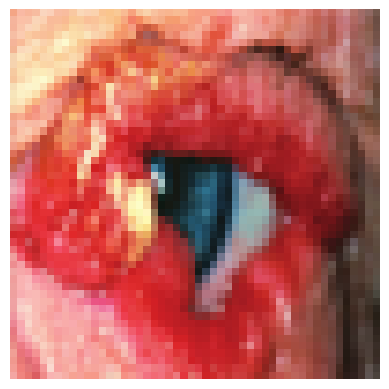

In [7]:
image_data = data.iloc[0, :-1]  
image_array = np.array(image_data, dtype=np.uint8).reshape(50, 50, 3)


plt.imshow(image_array)
plt.axis('off')  
plt.show()

In [8]:
X = data.iloc[:, :-1]  # Features (pixel values)
y = data.iloc[:, -1]   # Labels

# Split the data into training and temporary (test + validation) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 9915
Validation set size: 3305
Test set size: 3306


In [9]:
def rgb_to_grayscale(rgb_values):
    # Reshape row to 50x50x3 array
    rgb_array = np.array(rgb_values, dtype=np.uint8).reshape(50, 50, 3)
    # --Calculate grayscale values using the formula. The formula aligns with the Rec. 709 standard (also used in HDTV formats)
    grayscale_array = 0.2989 * rgb_array[:,:,0] + 0.5870 * rgb_array[:,:,1] + 0.1140 * rgb_array[:,:,2]
    return np.round(grayscale_array).astype(np.uint8).flatten()


X_train = X_train.apply(pd.to_numeric, errors='coerce')
grayscale_images = X_train.apply(lambda x: rgb_to_grayscale(x), axis=1)


c:\Users\liita\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\series.py:1022: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


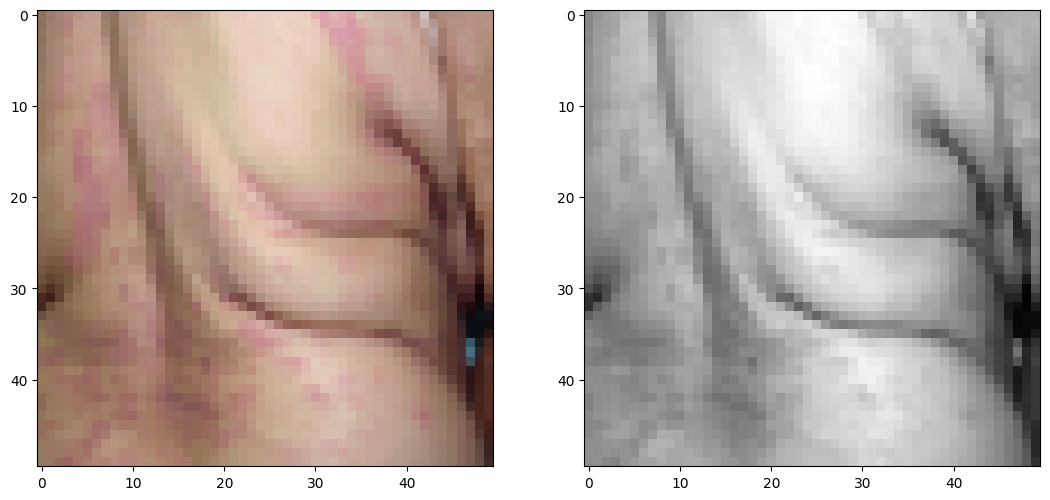

In [10]:
img = X_train.iloc[11]
img =  np.array(img, dtype=np.uint8).reshape(50, 50, 3)

img_in = rgb_to_grayscale(img)
image_reshaped = np.array(img_in, dtype=np.uint8).reshape(50, 50)

# Plot the image
plt.figure(figsize=(20,10))
plt.subplot(131); plt.imshow(img)
plt.subplot(132); plt.imshow(image_reshaped, cmap='gray')
plt.show()

### Histogram Equalization

In [11]:
def histogram_eq(img, bines):

    img = np.array(img, dtype=np.uint8).reshape(50, 50, 3)

    #count the number of pixels
    n = img.size

    #Get tje gary level histogram
    r = img.flatten() #0=black 255=white
    histogram, bins = np.histogram(r, bines, [0,bines])

    Pf = histogram/n

    #Get the cumulative distribution function
    cdf = np.cumsum(Pf)
    T = (bines-1)*cdf
    Trounding = np.round(T).astype('uint8')

    #Apply the transformation
    img_eq = Trounding[r].reshape(img.shape)

    return img_eq

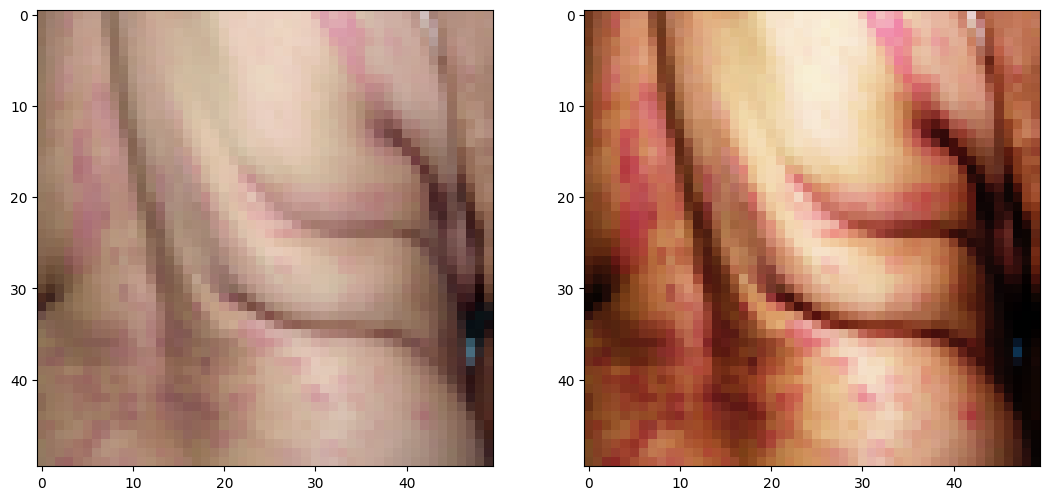

In [12]:
img = X_train.iloc[11]
img =  np.array(img, dtype=np.uint8).reshape(50, 50, 3)

img_in = histogram_eq(img,250)
image_reshaped = np.array(img_in, dtype=np.uint8).reshape(50, 50,3)

# Plot the image
plt.figure(figsize=(20,10))
plt.subplot(131); plt.imshow(img)
plt.subplot(132); plt.imshow(image_reshaped, cmap='gray')
plt.show()

### Thresholding based segmentation

In [13]:
def thresholding(f, L):
    f_tr = np.zeros(f.shape).astype('uint8')  # Initialize to zeros (background)
    f_tr[f <= L] = 255  
    return f_tr

Text(0.5, 1.0, 'Threshold 100')

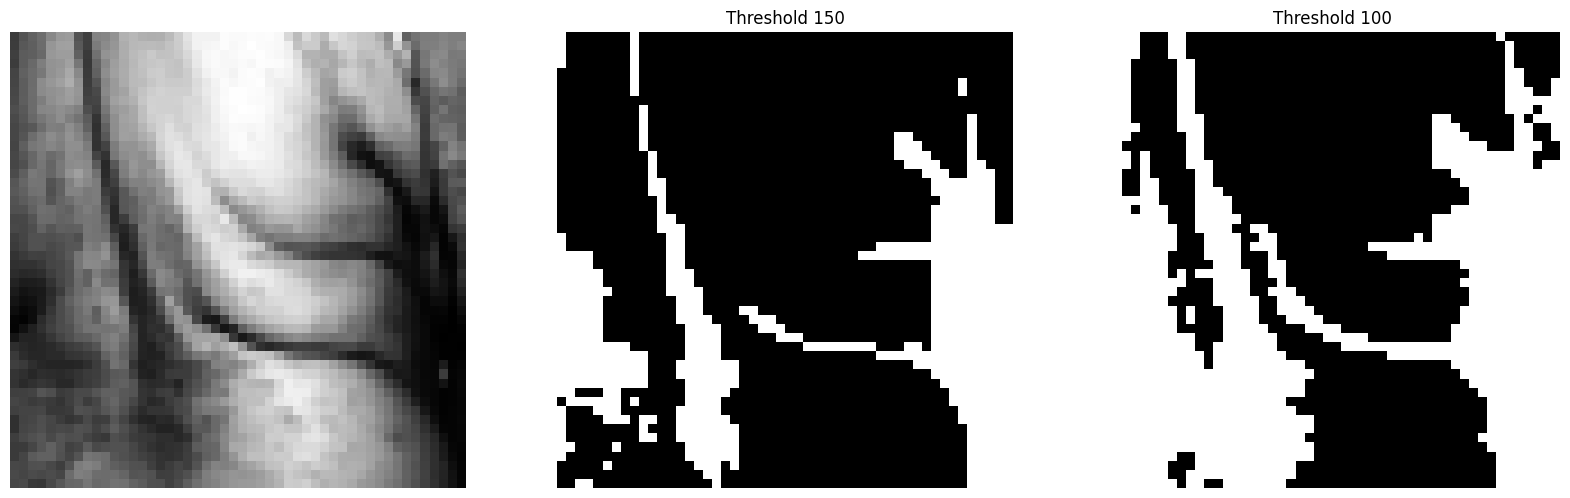

In [14]:
img = X_train.iloc[11]
img =  np.array(img, dtype=np.uint8).reshape(50, 50, 3)

img_in = histogram_eq(img,250)


f = np.array(img_in, dtype=np.uint8).reshape(50, 50,3)

f = cv2.cvtColor(f, cv2.COLOR_BGR2GRAY)

#mean_v= np.mean(f)
hist,_=np.histogram(f, bins=256, range=(0,256))


t_thres6= thresholding(f, 60)
hist_t6, _ = np.histogram(t_thres6*256, bins = 256 , range=(0,256))

t_thres100= thresholding(f, 100)
hist_t100, _ = np.histogram(t_thres100*256, bins = 256 , range=(0,256))

# Plot the image
plt.figure(figsize=(20,10))
plt.subplot(131); plt.imshow(f, cmap='gray'); plt.axis ('off')
plt.subplot(132); plt.imshow(t_thres6, cmap='gray'); plt.axis ('off');plt.title('Threshold 150')
plt.subplot(133); plt.imshow(t_thres100, cmap='gray'); plt.axis ('off');plt.title('Threshold 100')

##### Otsu thresholding

In [15]:
#Otsu thresholding
def otsu_threshold(img):
    max_L = 256
    hist_t, bin_edges = np.histogram(img, bins=max_L, range=(0, max_L))
    M = np.product(img.shape)
    best_threshold = 0
    min_var = float('inf')

    for L in range(1, max_L - 1):
        w_a = np.sum(hist_t[:L]) / M
        w_b = np.sum(hist_t[L:]) / M
        sig_a = np.var(img[img < bin_edges[L]])
        sig_b = np.var(img[img >= bin_edges[L]])

        within_class_variance = w_a * sig_a + w_b * sig_b
        if within_class_variance < min_var:
            min_var = within_class_variance
            best_threshold = L

    img_t = thresholding(img, best_threshold)
    return img_t, best_threshold


In [16]:
def rgb_to_grayscale(rgb_values):
    rgb_array = np.array(rgb_values, dtype=np.uint8).reshape(50, 50, 3)
    grayscale_array = 0.2989 * rgb_array[:,:,0] + 0.5870 * rgb_array[:,:,1] + 0.1140 * rgb_array[:,:,2]
    return np.round(grayscale_array).astype(np.uint8)

In [17]:
def pipeline(X):
    X = X.apply(pd.to_numeric, errors='coerce')
    grayscale_image = rgb_to_grayscale(X)  
    otsu_image, threshold = otsu_threshold(grayscale_image)

    eq_image = histogram_eq(img, 256)    

    return otsu_image, grayscale_image, eq_image, X

C:\Users\liita\AppData\Local\Temp\ipykernel_3484\1903017961.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  otsu_image, threshold = otsu_threshold(grayscale_image)
c:\Users\liita\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\liita\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\liita\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


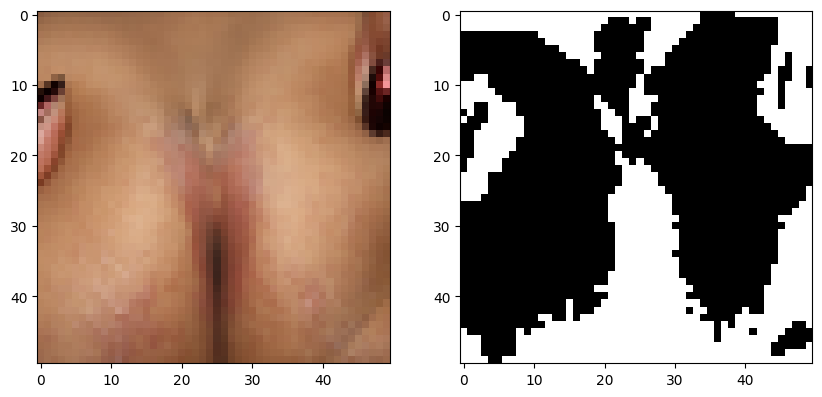

In [18]:
img = X_train.iloc[13]
img_in = pipeline(img)[0]

# Plot the image
plt.figure(figsize=(10, 5))
plt.subplot(121); plt.imshow(np.array(img, dtype=np.uint8).reshape(50, 50, 3))
plt.subplot(122); plt.imshow(img_in, cmap='gray')
plt.show()

#### Augment

In [19]:
IMG_SIZE = 180

resize_and_rescale = Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

In [20]:
data_augmentation = Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.4),
])

#### Apply pipeline to all datasets

In [21]:
def pipeline(df):
    df = df.apply(pd.to_numeric, errors='coerce')
    
    def process_row(row):
        grayscale_image = rgb_to_grayscale(row)  
        otsu_image, _ = otsu_threshold(grayscale_image)
        eq_image = histogram_eq(row, 256)
        return pd.Series({ 'grayscale_image': grayscale_image, 'otsu_image': otsu_image, 'eq_image': eq_image})

    
    processed_df = df.apply(process_row, axis=1) # To each row

    return processed_df

In [22]:
results_train =  pipeline(X_train)
results_val =  pipeline(X_val)
results_test =  pipeline(X_test)

C:\Users\liita\AppData\Local\Temp\ipykernel_3484\453918214.py:6: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  otsu_image, _ = otsu_threshold(grayscale_image)
C:\Users\liita\AppData\Local\Temp\ipykernel_3484\453918214.py:6: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  otsu_image, _ = otsu_threshold(grayscale_image)
c:\Users\liita\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\liita\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\liita\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_met

In [23]:
# Datasets 
grayscale_train =  pd.DataFrame([x.flatten() for x in results_train['grayscale_image']])
otsu_train = pd.DataFrame([x.flatten() for x in results_train['otsu_image']])
eq_train = pd.DataFrame([x.flatten() for x in results_train['eq_image']])

grayscale_val = pd.DataFrame([x.flatten() for x in results_val['grayscale_image']])
otsu_val = pd.DataFrame([x.flatten() for x in results_val['otsu_image']])
eq_val =  pd.DataFrame([x.flatten() for x in results_val['eq_image']])

grayscale_test =  pd.DataFrame([x.flatten() for x in results_test['grayscale_image']])
otsu_test =  pd.DataFrame([x.flatten() for x in results_test['otsu_image']])
eq_test = pd.DataFrame([x.flatten() for x in results_test['eq_image']])

### Model

In [76]:
# Image input branch 1
image_input = Input(shape=(50, 50, 1))
x1 = resize_and_rescale
x1 =  data_augmentation
x1 = Conv2D(32, (3, 3), activation='relu')(image_input)
x1 = MaxPooling2D((2, 2))(x1)
# x1 = Conv2D(64, (3, 3), activation='sigmoid')(x1)
# x1 = MaxPooling2D((2, 2))(x1)
x1 = Conv2D(128, (3, 3), activation='relu')(x1)
x1 = MaxPooling2D((2, 2))(x1)
x1 = Conv2D(128, (3, 3), activation='relu')(x1)
x1 = MaxPooling2D((2, 2))(x1)
x1 = Flatten()(x1)

# Image input branch 2
image_input2 = Input(shape=(50, 50, 1))
x2 = resize_and_rescale
x2 =  data_augmentation
x2 = Conv2D(32, (3, 3), activation='relu')(image_input2)
x2 = MaxPooling2D((2, 2))(x2)
# x2 = Conv2D(64, (3, 3), activation='sigmoid')(x2)
# x2 = MaxPooling2D((2, 2))(x2)
x2 = Conv2D(128, (3, 3), activation='relu')(x2)
x2 = MaxPooling2D((2, 2))(x2)
x2 = Conv2D(128, (3, 3), activation='relu')(x2)
x2 = MaxPooling2D((2, 2))(x2)
x2 = Flatten()(x2)

# Image input branch 3
image_input3 = Input(shape=(50, 50, 3))
x3 = resize_and_rescale
x3 =  data_augmentation
x3 = Conv2D(32, (3, 3), activation='relu')(image_input2)
x3 = MaxPooling2D((2, 2))(x3)
# x3 = Conv2D(64, (3, 3), activation='sigmoid')(x3)
# x3 = MaxPooling2D((2, 2))(x3)
x3 = Conv2D(128, (3, 3), activation='relu')(x3)
x3 = MaxPooling2D((2, 2))(x3)
x3 = Conv2D(128, (3, 3), activation='relu')(x3)
x3 = MaxPooling2D((2, 2))(x3)
x3 = Flatten()(x3)


# Concatenate 
combined = Concatenate()([x1, x2,x3])

# Fully connected layers
x = Dense(512, activation='relu')(combined)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(115, activation='softmax')(x)  


model = Model(inputs=[image_input, image_input2,image_input3], outputs=output)

model.compile(optimizer= RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
# Print model summary
#model.summary()

In [26]:
X_train_grayscale = grayscale_train.astype('float32')
X_train_otsu = otsu_train.astype('float32')
X_train_eq = eq_train.astype('float32')

X_val_grayscale = grayscale_val.astype('float32')
X_val_otsu = otsu_val.astype('float32')
X_val_eq = eq_val.astype('float32')

X_test_grayscale = grayscale_test.astype('float32')
X_test_otsu = otsu_test.astype('float32')
X_test_eq = eq_test.astype('float32')

In [27]:
#Import Label Encoder
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)


num_classes = len(label_encoder.classes_)
y_train_one_hot = to_categorical(y_train_encoded, num_classes=num_classes)


y_val_encoded = label_encoder.transform(y_val)
y_val_one_hot = to_categorical(y_val_encoded, num_classes=num_classes)

y_test_encoded = label_encoder.transform(y_test)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=num_classes)


X_train_grayscale = np.reshape(X_train_grayscale, (-1, 50, 50, 1))
X_val_grayscale = np.reshape(X_val_grayscale, (-1, 50, 50, 1))
X_test_grayscale = np.reshape(X_test_grayscale, (-1, 50, 50, 1))

X_train_otsu = np.reshape(X_train_otsu, (-1, 50, 50, 1))
X_val_otsu = np.reshape(X_val_otsu, (-1, 50, 50, 1))
X_test_otsu = np.reshape(X_test_otsu, (-1, 50, 50, 1))

X_train_eq = np.reshape(X_train_eq, (-1, 50, 50, 3))
X_val_eq = np.reshape(X_val_eq, (-1, 50, 50, 3))
X_test_eq = np.reshape(X_test_eq, (-1, 50, 50, 3))

In [77]:
history = model.fit(
    x=[X_train_grayscale, X_train_otsu, X_train_eq],  # Input data for each branch
    y=y_train_one_hot ,  # Target labels
    epochs=20,
    batch_size=200,
    validation_data=([X_val_grayscale, X_val_otsu, X_val_eq], y_val_one_hot)  # Validation data for each branch
    ,
)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.0228 - loss: 5.2979 - val_accuracy: 0.0148 - val_loss: 9.8150
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.0388 - loss: 4.7052 - val_accuracy: 0.0260 - val_loss: 8.4973
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.0551 - loss: 4.5058 - val_accuracy: 0.0191 - val_loss: 5.2617
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.0727 - loss: 4.3055 - val_accuracy: 0.0194 - val_loss: 5.6353
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.0864 - loss: 4.1377 - val_accuracy: 0.0297 - val_loss: 5.2532
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.1142 - loss: 3.9343 - val_accuracy: 0.0266 - val_loss: 5.0697
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.1416 - loss: 3.7578 - val_accuracy: 0.0342 - val_loss: 5.1815
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.1960 - loss: 3.4635 - val_accuracy: 0.0436 - val_loss:

In [78]:
# Save the model
model.save('model.h5')

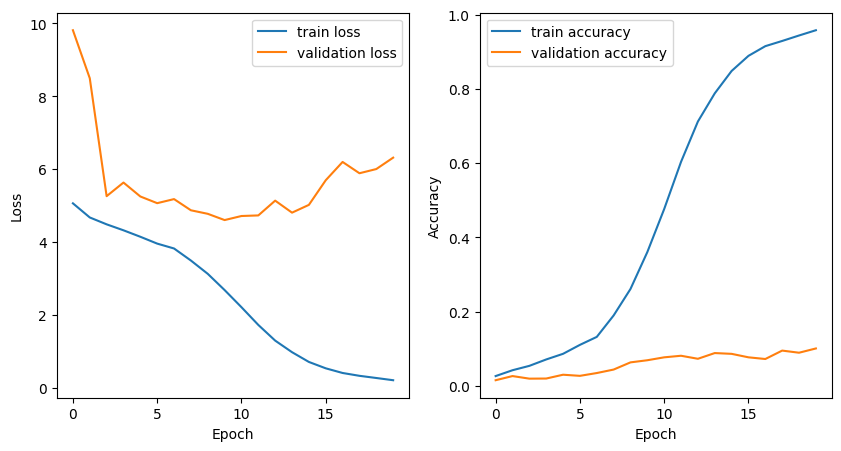

In [79]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [80]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


test_predictions = model.predict([X_test_grayscale, X_test_otsu, X_test_eq])
predicted_classes = np.argmax(test_predictions, axis=1)

true_classes = np.argmax(y_test_one_hot, axis=1)  

104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step


In [81]:

# Calcular la precisión
accuracy = accuracy_score(true_classes, predicted_classes)
print("Accuracy:", accuracy)

#Print F1 score
from sklearn.metrics import f1_score
f1 = f1_score(true_classes, predicted_classes, average='weighted')
print("F1 Score:", f1)

f1 = f1_score(true_classes, predicted_classes, average='macro')
print("F1 macroScore:", f1)

#print precision and recall
from sklearn.metrics import precision_score, recall_score
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
print("Precision:", precision)
print("Recall:", recall)


Accuracy: 0.09528130671506352
F1 Score: 0.08685410464559425
F1 macroScore: 0.07928348919055205
Precision: 0.1068728561224557
Recall: 0.09528130671506352


c:\Users\liita\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Grad-CAM Algorithm

In [82]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

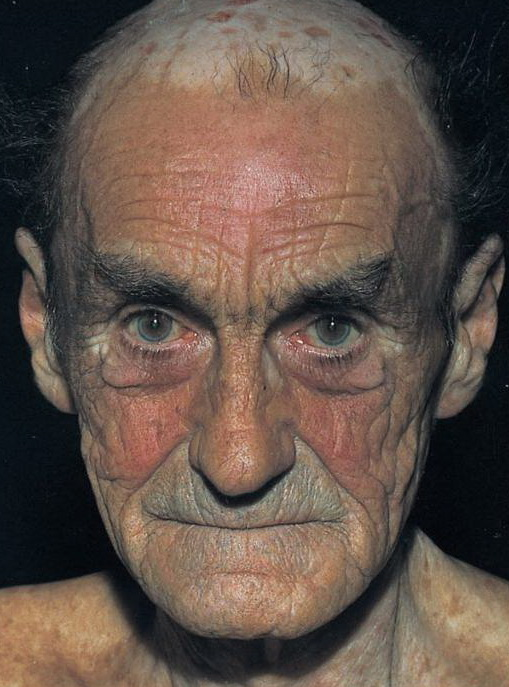

In [87]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# The local path to our target image
img_path ="C:/Users/liita/OneDrive/Documentos/Nova IMS/Deep learning/Proyecto/Descarga Imagenes/porphyria/img9150.jpg" #Mal clasificado de uno que no clasifica bien

display(Image(img_path))

In [88]:
def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))


    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted: [('n04357314', 'sunscreen', 4.983275)]


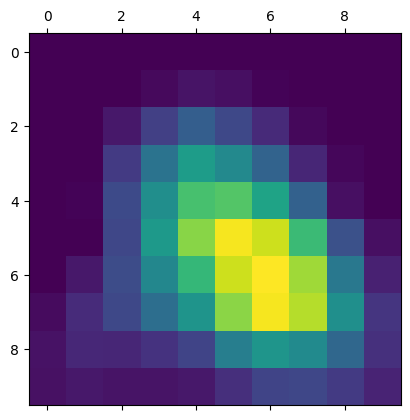

In [89]:

img_array = preprocess_input(get_img_array(img_path, size=img_size))

model = model_builder(weights="imagenet")

model.layers[-1].activation = None

preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

plt.matshow(heatmap)
plt.show()

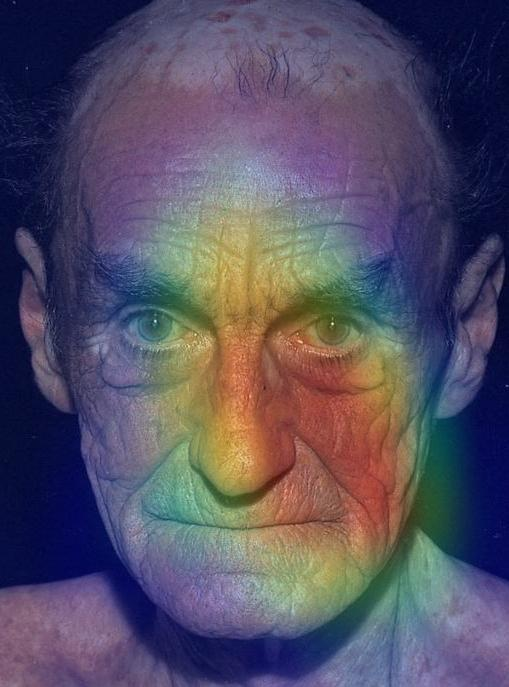

In [90]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)
    heatmap = np.uint8(255 * heatmap)

    jet = mpl.colormaps["jet"]

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)

    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

### Pre-trained model

In [49]:
from keras.applications import MobileNetV2
from keras.layers import Dense, GlobalAveragePooling2D

In [91]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(115, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)  # num_classes 


model2 = Model(inputs=base_model.input, outputs=predictions)


for layer in base_model.layers:
    layer.trainable = False

model2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [93]:
def preprocess_images(images):
    # Resize images to the expected size 
    return tf.image.resize(images, [224, 224])

X_train_eq_resized = preprocess_images(X_train_eq)
X_val_eq_resized = preprocess_images(X_val_eq)


model2.fit(X_train_eq_resized, y_train_one_hot, epochs=60, batch_size=200,
          validation_data=(X_val_eq_resized, y_val_one_hot))

Epoch 1/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 237s 3s/step - accuracy: 0.1291 - loss: 3.8821 - val_accuracy: 0.0829 - val_loss: 4.1967
Epoch 2/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 169s 3s/step - accuracy: 0.1290 - loss: 3.8451 - val_accuracy: 0.0832 - val_loss: 4.2122
Epoch 3/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.1316 - loss: 3.8173 - val_accuracy: 0.0865 - val_loss: 4.1688
Epoch 4/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 180s 4s/step - accuracy: 0.1385 - loss: 3.7498 - val_accuracy: 0.0856 - val_loss: 4.1525
Epoch 5/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - accuracy: 0.1510 - loss: 3.7071 - val_accuracy: 0.0844 - val_loss: 4.1830
Epoch 6/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - accuracy: 0.1509 - loss: 3.6779 - val_accuracy: 0.0920 - val_loss: 4.1939
Epoch 7/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - accuracy: 0.1621 - loss: 3.6343 - val_accuracy: 0.0908 - val_loss: 4.1680
Epoch 8/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.1760 - loss: 3.5973 - val_accuracy: 0.0884 - v

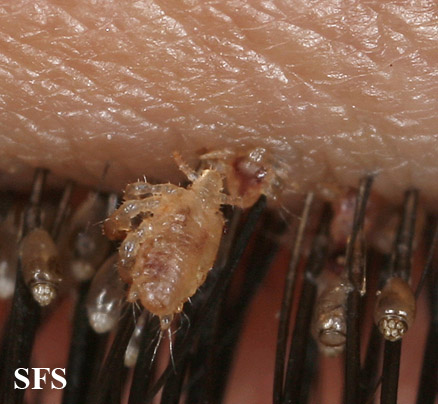

In [73]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# The local path to our target image
#img_path ="C:/Users/liita/OneDrive/Documentos/Nova IMS/Deep learning/Proyecto/Descarga Imagenes/acne/img3434.jpg"
#img_path ="C:/Users/liita/OneDrive/Documentos/Nova IMS/Deep learning/Proyecto/Descarga Imagenes/basal cell carcinoma/img2769.jpg"

img_path ="C:/Users/liita/OneDrive/Documentos/Nova IMS/Deep learning/Proyecto/Descarga Imagenes/pediculosis lids/img12858.jpg"

display(Image(img_path))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted: [('n01770081', 'harvestman', 7.0720444)]


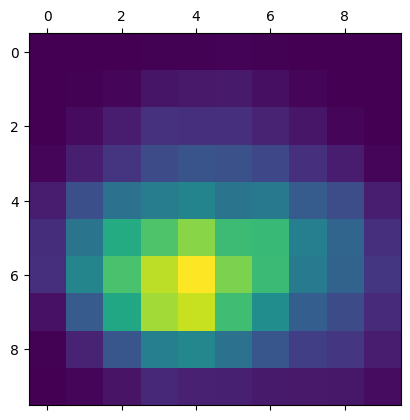

In [74]:

img_array = preprocess_input(get_img_array(img_path, size=img_size))


model = model_builder(weights="imagenet")


model.layers[-1].activation = None


preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])


heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

plt.matshow(heatmap)
plt.show()

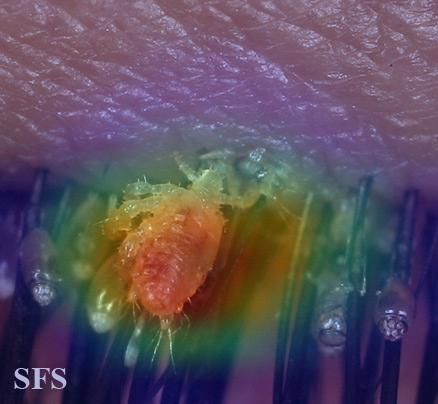

In [75]:
save_and_display_gradcam(img_path, heatmap)